In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from prepare_hess_dataset_large_hdf5 import MyDataset
from prepare_hess_dataset_large_hdf5 import get_event_images
import random

import torch
from torch_geometric.data import Data
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataLoader

import networkx as nx
from torch_geometric.utils import to_networkx, to_scipy_sparse_matrix
import torch_geometric.transforms as T

In [2]:
def remove_tel_loc_offset_for_vis(data):
    xy = dict()
    xype = list()
    offset = 83 # in m
    for i, px_pos in enumerate(data.x):
        xy_temp = px_pos.numpy()
        if(xy_temp[0] > offset):
            xy_temp[0] = xy_temp[0] - offset
        elif(xy_temp[0] < -offset):
            xy_temp[0] = xy_temp[0] + offset
        elif(xy_temp[1] > offset):
            xy_temp[1] = xy_temp[1] - offset
        elif(xy_temp[1] < -offset):
            xy_temp[1] = xy_temp[1] + offset
        xy[i] = xy_temp[:-1]
        xype.append(xy_temp)
    return xy, np.array(xype)

In [3]:
def visualize_graph(data):
    adj = to_scipy_sparse_matrix(data.edge_index, edge_attr=data.edge_attr, num_nodes=data.num_nodes)
    xy, _ = remove_tel_loc_offset_for_vis(data)
    plt.figure(figsize=(18,18))
    plt.xticks([])
    plt.yticks([])
    G = nx.from_scipy_sparse_matrix(adj)
    nx.draw(G, pos=xy, node_size=data.x[:,[2]], width=0.3, cmap=plt.get_cmap('viridis'))

#### get the dataset and have a look

In [4]:
analysis_type = 'mono'
indir = '/home/saturn/caph/mppi067h/graph_datasets/phase2d3/'
outdir = '/home/saturn/caph/mppi067h/graph_datasets/phase2d3/' +  analysis_type
out_model_dir = '/home/woody/caph/mppi067h/gamma_ray_reconstruction_with_ml/gnn/trained_models/phase2d3/' + analysis_type
dataset_name = 'test'

dataset = MyDataset(outdir,dataset_name,indir,1)

In [5]:
plots_dir = '/home/woody/caph/mppi067h/gamma_ray_reconstruction_with_ml/gnn/plots/test/' + analysis_type
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

#### make train and test split

In [6]:
final_dataset = list()
cr_types = ['gamma']#,'proton']
for cr_type in cr_types:
    for idx in range(1):
        final_dataset += dataset.get(cr_type,idx)

random.shuffle(final_dataset)

train_dataset = final_dataset[:int(0.9*len(final_dataset))]
test_dataset = final_dataset[int(0.9*len(final_dataset)):]

#### print some information about the datasets

In [7]:
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

print()
print('====================')
print(f'Number of total graphs: {len(final_dataset)}')

data = test_dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Number of training graphs: 1690
Number of test graphs: 188

Number of total graphs: 1878

Data(x=[1764, 3], y=[1, 12], edge_index=[2, 10584])
Number of nodes: 1764
Number of edges: 10584
Average node degree: 6.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False


#### have a look at example graphs

In [8]:
gamma_file_number = 0
gamma_event_number = 0
proton_file_number = 0
proton_event_number = 1
data_gamma = dataset.get('gamma',gamma_file_number)[gamma_event_number]
data_proton = dataset.get('proton',proton_file_number)[proton_event_number]

/home/woody/caph/mppi067h/anaconda3/envs/gnn/lib/python3.9/site-packages/matplotlib/collections.py:980: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<Figure size 432x288 with 0 Axes>

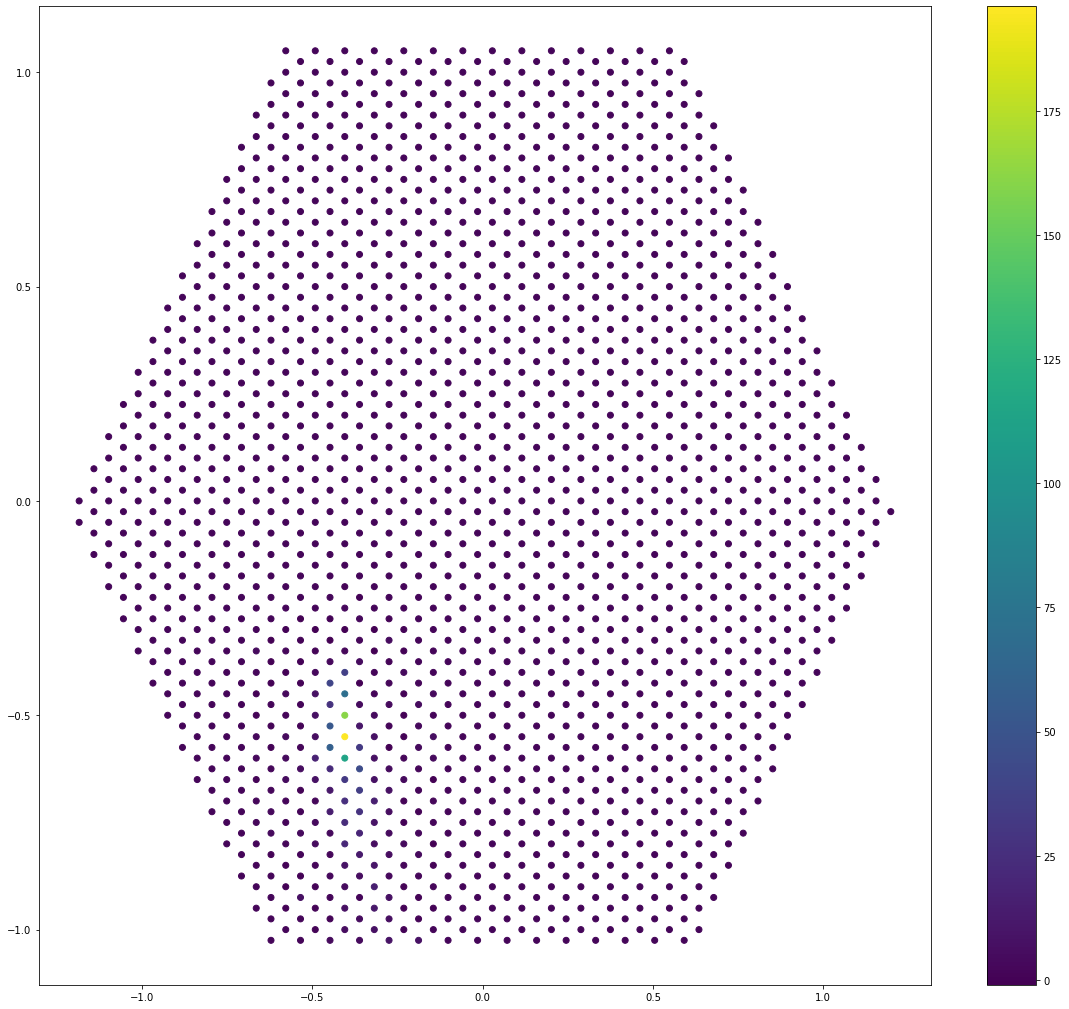

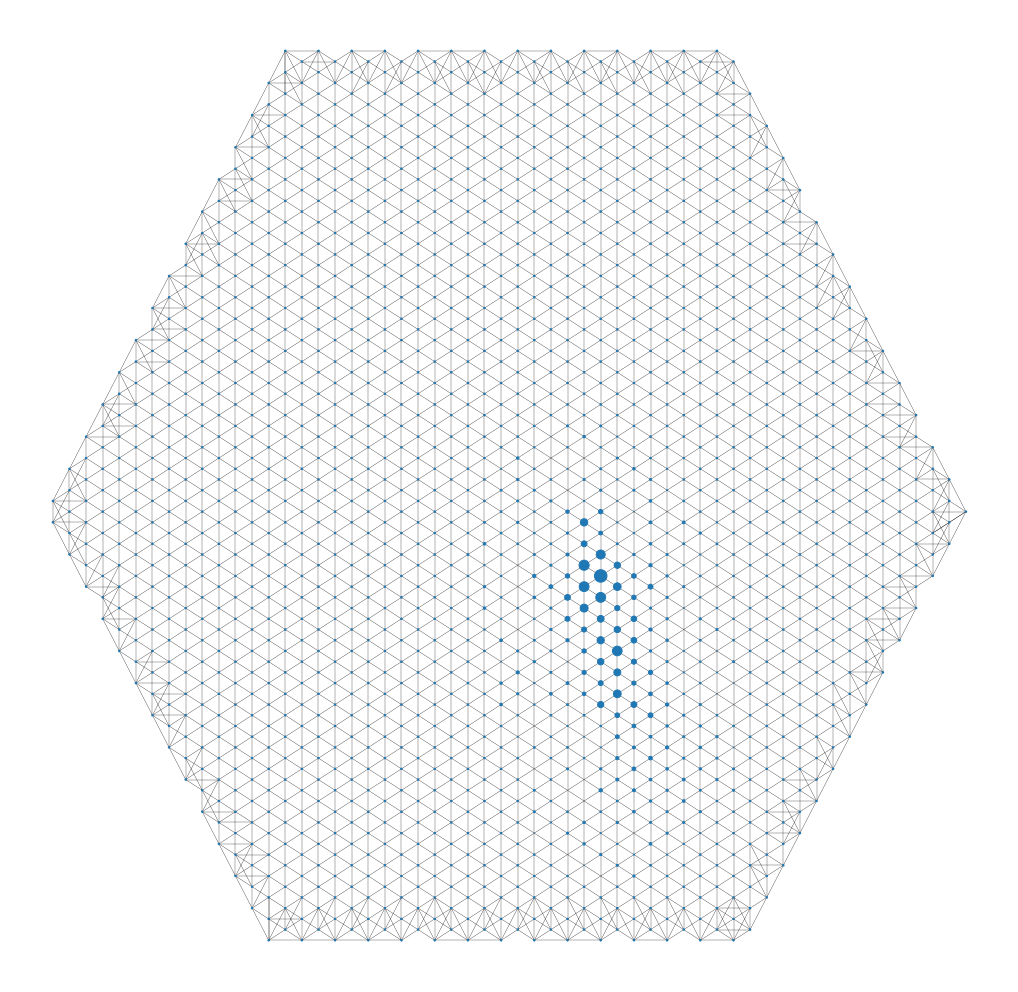

In [9]:
_, xype = remove_tel_loc_offset_for_vis(data_gamma)
plt.savefig(plots_dir + f'/gamma_enent.png', bbox_inches='tight')
plt.savefig(plots_dir + f'/gamma_enent.png', bbox_inches='tight')
plt.figure(figsize=(20,18))
#plt.scatter(xype[:,[0]], xype[:,[1]], c=xype[:,[2]]);
plt.scatter(data.x[:,[0]], data.x[:,[1]], c=data.x[:,[2]]);
plt.colorbar()
visualize_graph(data_gamma)
plt.savefig(plots_dir + '/' +  f'/gamma_enent_graph.png', bbox_inches='tight')
plt.savefig(plots_dir + '/' +  f'/gamma_enent_graph.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

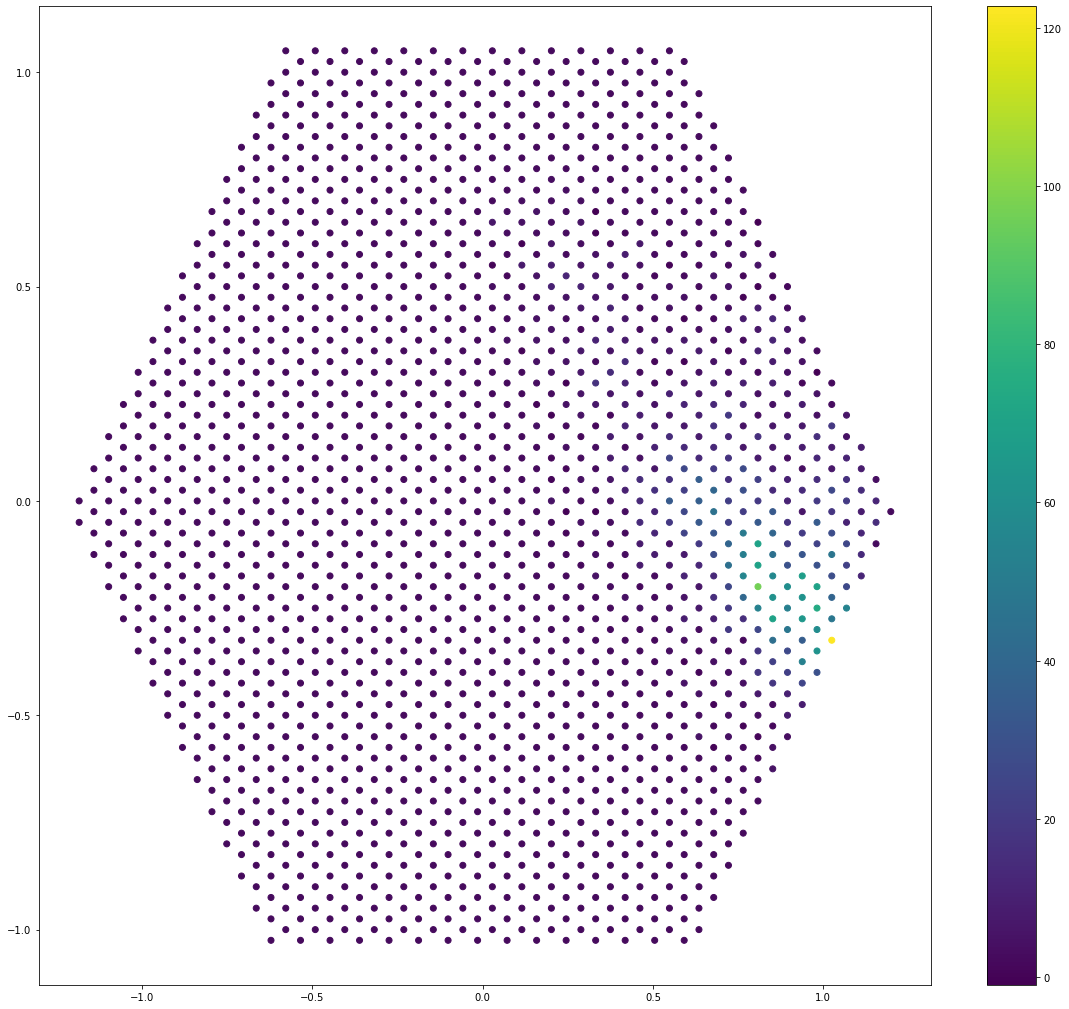

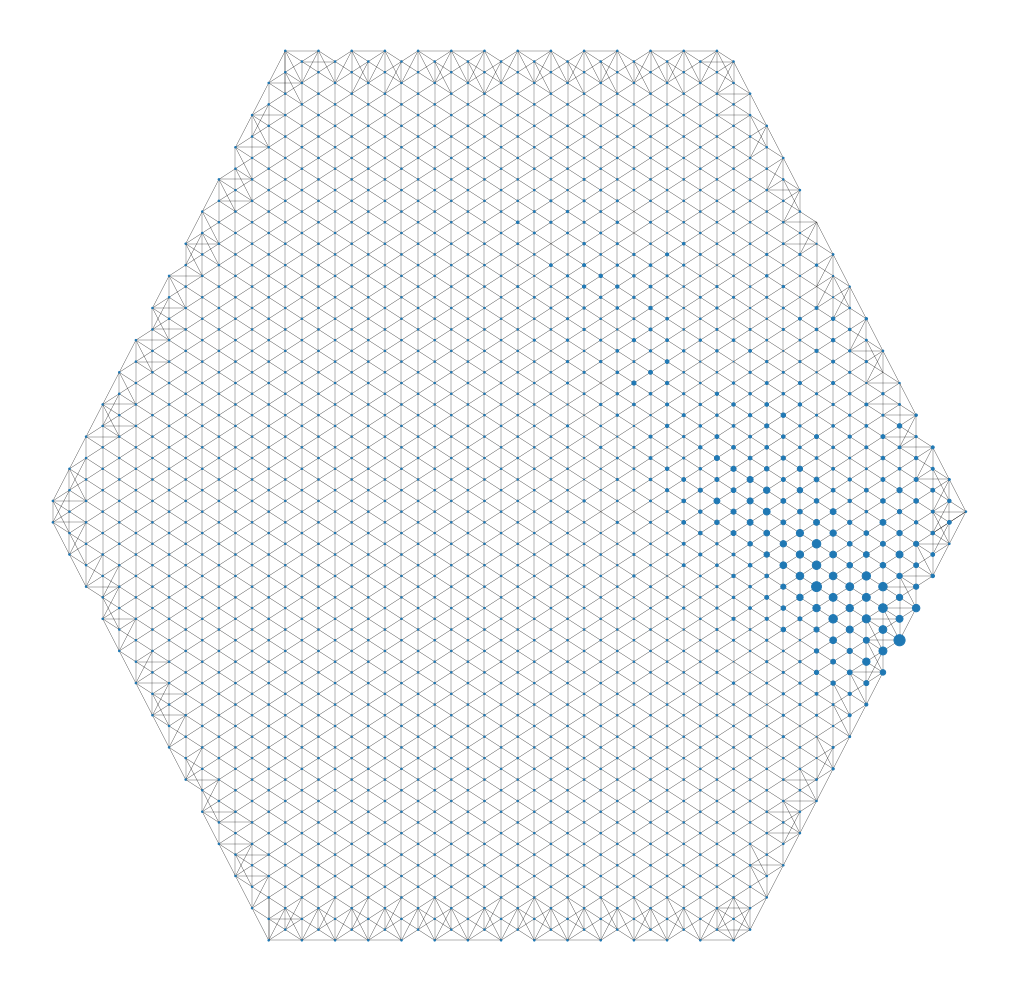

In [10]:
_, xype = remove_tel_loc_offset_for_vis(data_proton)
plt.savefig(plots_dir + f'/proton_enent.png', bbox_inches='tight')
plt.savefig(plots_dir + f'/proton_enent.pdf', bbox_inches='tight')
plt.figure(figsize=(20,18))
plt.scatter(xype[:,[0]], xype[:,[1]], c=xype[:,[2]]);
plt.colorbar()
visualize_graph(data_proton)
plt.savefig(plots_dir + f'/proton_enent_graph.png', bbox_inches='tight')
plt.savefig(plots_dir + f'/proton_enent_graph.pdf', bbox_inches='tight')

#### Some other stuff we don't need necessarily

Gamma
0 0
2740.295066833496
Proton
0 1
7388.018890380859


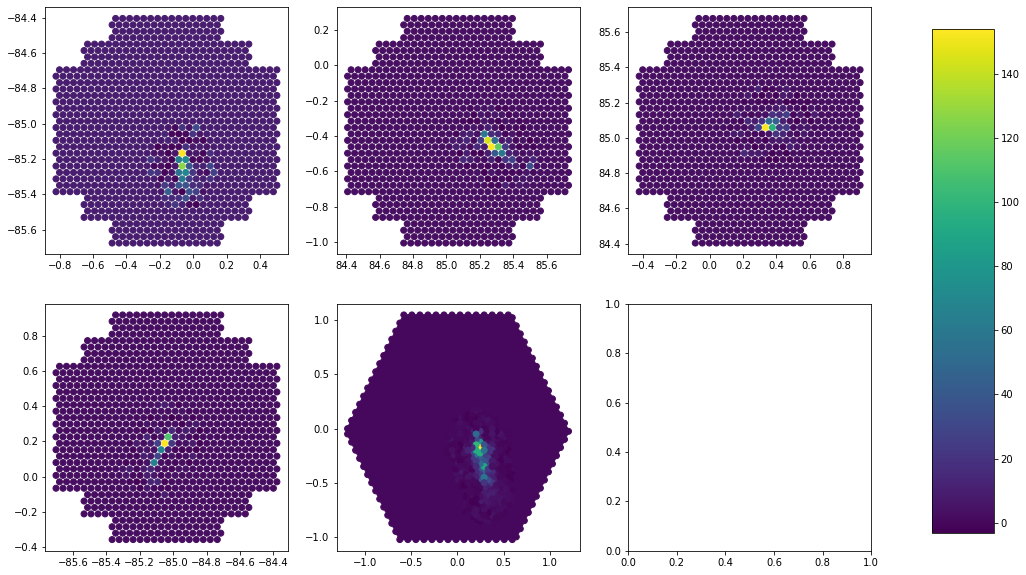

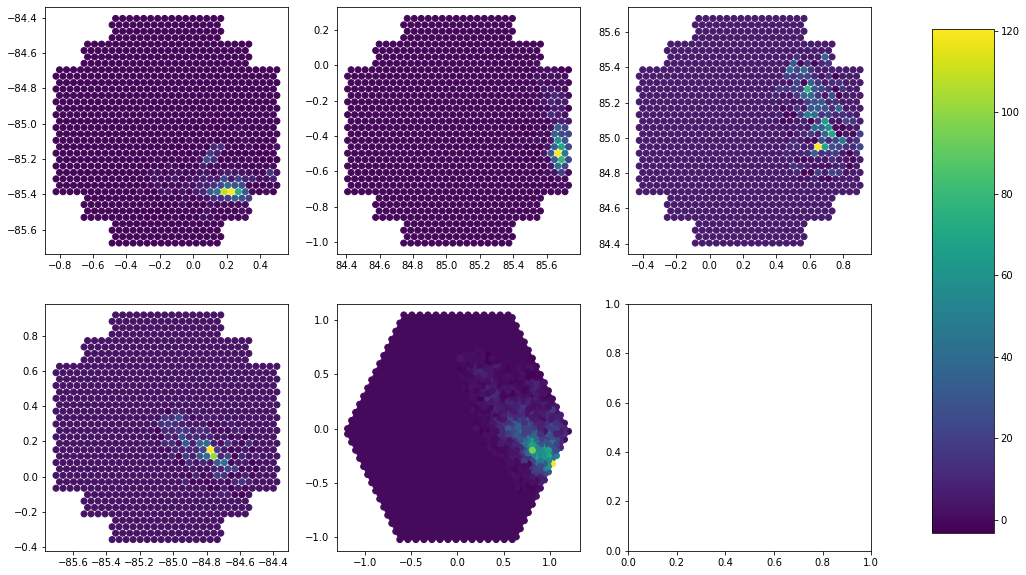

In [10]:
#gamma_event
print('Gamma')
cam_pixels_in_array, tel_images = get_event_images(dataset, 'gamma', gamma_file_number, gamma_event_number)
fig, axs = plt.subplots(2,3,figsize=(17,10))
total_pe = 0
for tel,ax in enumerate(axs.flatten()):
    if tel > 4:
        continue
    tel_key = f'ct{tel+1}'
    ax_temp = ax.scatter(cam_pixels_in_array[tel_key][0],cam_pixels_in_array[tel_key][1], c=tel_images[tel_key])
    total_pe += tel_images[tel_key].sum()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax_temp, cax=cbar_ax)
print(total_pe)
#proton event
print('Proton')
cam_pixels_in_array, tel_images = get_event_images(dataset, 'proton', proton_file_number, proton_event_number)
fig, axs = plt.subplots(2,3,figsize=(17,10))
total_pe = 0
for tel,ax in enumerate(axs.flatten()):
    if tel > 4:
        continue
    tel_key = f'ct{tel+1}'
    ax_temp = ax.scatter(cam_pixels_in_array[tel_key][0],cam_pixels_in_array[tel_key][1], c=tel_images[tel_key])
    total_pe += tel_images[tel_key].sum()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax_temp, cax=cbar_ax)
print(total_pe)

#### define the model

In [11]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

#### load the test and train datasets

In [12]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [13]:
for step, data in enumerate(train_loader):
    print(data, step, data.y[:,0:2])
    if(step > 1):
        break

DataBatch(x=[5604, 3], y=[1, 12], edge_index=[2, 33624], batch=[5604], ptr=[2]) 0 tensor([[5., 1.]], dtype=torch.float64)
DataBatch(x=[5604, 3], y=[1, 12], edge_index=[2, 33624], batch=[5604], ptr=[2]) 1 tensor([[5., 1.]], dtype=torch.float64)
DataBatch(x=[3840, 3], y=[1, 12], edge_index=[2, 23040], batch=[3840], ptr=[2]) 2 tensor([[4., 0.]], dtype=torch.float64)


In [14]:
(3684-1764)/960

2.0

In [15]:
data.x.shape

torch.Size([3840, 3])

In [16]:
plt.scatter(test_proton_df.true_energy, test_proton_df.score)

NameError: name 'test_proton_df' is not defined

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data.y.shape

In [ ]:
torch.round(torch.tensor(data.y)[:,-1])

In [ ]:
test[:,-1]

In [ ]:
data.y[[-1]]

#### have a look at the train dataset

In [ ]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print("number of node features:", data.num_node_features)
    if(step > 1):
        break

#### setup for trainging

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)
model = GCN(hidden_channels=64,num_node_features=3).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

#### define train and test function

In [ ]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

#### run the model

In [ ]:
for epoch in range(1, 30):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


In [ ]:
a = np.arange(1,10)
b = np.arange(11,20)
c = a*b
c

In [ ]:
[0.4533, 0.5467],
        [0.3408, 0.6592],

In [ ]:
0.4533 +0.5467

In [ ]:
0.3408 +0.6592